# Wheel Test 2018-10-02
Testing rev 3 wheels - printed on Jif.

In [1]:
%matplotlib inline
import pandas as pd

In [2]:
date = '2018-10-02'
activity_meta = pd.read_pickle("data/meta-%s.pkl.gz" % date)
activity_data = pd.read_pickle("data/data-%s.pkl.gz" % date)

## TPI Grouped by Direction
Select and pivot summary data for an activity.

In [3]:
pivot = activity_data.pivot(index='id', columns='measure', values='value')
activity = pd.merge(activity_meta, pivot, on='id')
activity['tpi'] = activity['actual_ticks'] / activity['actual_distance']
activity[['direction','actual_distance', 'tpi']].groupby('direction').describe().round(1)

actual_distance                                                 \
                    count   mean  std    min    25%    50%    75%    max   
direction                                                                  
-90.0                10.0  134.0  0.3  133.6  133.9  134.0  134.1  134.8   
0.0                  10.0  128.8  1.0  127.2  128.0  129.2  129.5  130.0   
180.0                10.0  135.6  0.6  134.2  135.3  135.8  136.0  136.2   
90.0                 10.0  132.8  0.7  131.4  132.5  133.1  133.2  133.9   

            tpi                                                        
          count    mean   std     min     25%     50%     75%     max  
direction                                                              
-90.0      10.0  1868.5   5.8  1861.4  1864.3  1867.7  1873.5  1877.2  
0.0        10.0  1944.6  12.1  1930.0  1935.3  1940.7  1954.9  1962.8  
180.0      10.0  1848.3   6.8  1840.3  1844.5  1847.0  1849.9  1861.3  
90.0       10.0  1887.7   9.1  1872.8  1882.0  1887.2  1892.4  1902.5

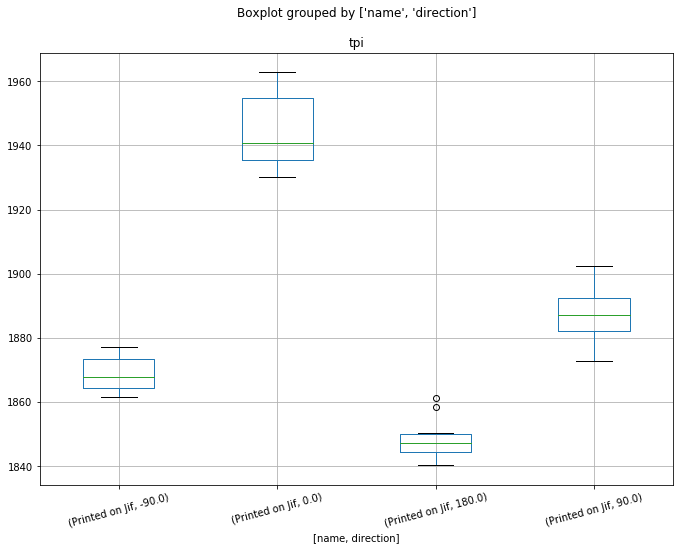

In [4]:
activity.boxplot(column='tpi', by=['name', 'direction'], rot=15, figsize=(11, 8))

## TPI Estimated Error by Direction
A resonable choice for nominal TPI is either *forward* TPI or TPI *grand mean*. We'll assume the TPI nominal value is the grand mean of all TPI measurements.

\begin{equation*}
error_{TPI} =  \frac{TPI_{experimental} - TPI_{nominal}}{TPI_{nominal}} \times 100\%
\end{equation*}

A positive error is more ticks per inch (conversely fewer inches per tick), therefore the robot travels less distance with postive error. The `100 in.` column below is how far we'd expect the robot to travel if we converted 100 in to ticks using the forward (0.0) TPI as our benchmark.

In [5]:
tpi_grand_mean = activity['tpi'].mean()
tpi_error = activity[['direction', 'tpi']].groupby('direction').mean()
tpi_error['error'] = (tpi_error['tpi'] - tpi_grand_mean) / tpi_grand_mean
tpi_error['error (%)'] = pd.Series(["{0:.2f}%".format(val * 100) for val in tpi_error['error']], index = tpi_error.index)

ticks_100_in = tpi_error.loc['0.0','tpi'] * 100 # ticks to travel 100in using 0.0 TPI
tpi_error['100 in.'] = ticks_100_in / tpi_error['tpi']
tpi_error = tpi_error.round({'tpi':1, 'error': 3, '100 in.': 2})
tpi_error

,tpi,error,error (%),100 in.
direction,,,,
-90.0,1868.5,-0.010,-0.99%,104.07
0.0,1944.6,0.030,3.03%,100.00
180.0,1848.3,-0.021,-2.06%,105.21
90.0,1887.7,0.000,0.02%,103.01


## Notes

The data for `activity_meta` can be reconstructed from the datebase with this query:
    
```sql
SELECT id, name, timestamp, meta->'direction' AS direction
FROM tc_activity
WHERE timestamp::date = date '2018-10-02' AND data[3] <> 0
```

The data for `activity_data` can be reconstructed from the datebase with this query:

```sql
SELECT id, name, timestamp, measure, value
FROM tc_activity, unnest(activity_measures, data) AS u(measure, value)
WHERE timestamp::date = date '2018-10-02' AND data[3] <> 0
```